In [2]:
# Step 2: Imports
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
# from imagenetv2_pytorch import ImageNetV2Dataset
from tqdm import tqdm

import torch
from torchvision import models, transforms
# from imagenetv2_pytorch import ImageNetV2
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy.special import softmax


In [2]:
# Step 3: Set device to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# Step 4: Load pretrained VGG16 model

##############ResNet101#################
model = models.vgg16(pretrained=True,progress=True)
model.eval()
model = model.to(device)



/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/nikhiljamuda/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.5MB/s] 


In [5]:
# #----for resnet101----------
transform = transforms.Compose([
    transforms.Resize(256),              # Resize shortest side to 256
    transforms.CenterCrop(224),          # Then take 224x224 center crop
    transforms.ToTensor(),               # Convert PIL Image to tensor
    transforms.Normalize(                # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],       # R, G, B means
        std=[0.229, 0.224, 0.225]         # R, G, B stds
    ),
])


 # Load the data set

In [6]:
num_calib = 5000

# Get the conformal calibcration dataset
imagenet_calib_data, imagenet_val_data ,imagenet_param_data= torch.utils.data.random_split(torchvision.datasets.ImageFolder('./imagenet_val/', transform), [num_calib,50000-num_calib-1000,1000])
batch_size = 128

# Reduce the size of the validation set to 10000
imagenet_val_data = torch.utils.data.Subset(imagenet_val_data, range(10000))

# Initialize loaders 
calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
param_loader = torch.utils.data.DataLoader(imagenet_param_data, batch_size=batch_size, shuffle=True, pin_memory=True)


In [8]:
# Step 8: Function to get logits and labels
def get_logits_and_labels(dataloader, model, device):
    logits_list, labels_list = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)  # Get logits
            logits_list.append(outputs.cpu())
            labels_list.append(labels)
    return torch.cat(logits_list), torch.cat(labels_list)



In [10]:
print("Getting test logits...")
test_logits, test_labels = get_logits_and_labels(test_loader, model, device)


Getting test logits...


100%|██████████| 79/79 [23:21<00:00, 17.75s/it]


In [11]:
# Step 10: Accuracy function
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Step 11: Compute test accuracy
accuracy = compute_accuracy(test_logits, test_labels)
print(f"VGG16 Accuracy on ImageNet-V2 test set: {accuracy * 100:.2f}%")



VGG16 Accuracy on ImageNet-V2 test set: 71.68%


 # Function for Conformal Prediction Procedures

In [12]:

def get_logits(model, dataloader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  
            logits_list.append(outputs.cpu())
            labels_list.append(labels)
    return torch.cat(logits_list), torch.cat(labels_list)

def temperature_scaling(logits, labels, max_iters=50, lr=0.01, epsilon=1e-4):
    T = nn.Parameter(torch.tensor([1.3], requires_grad=True))
    optimizer = optim.SGD([T], lr=lr)
    criterion = nn.CrossEntropyLoss()

    for i in range(max_iters):
        optimizer.zero_grad()
        scaled_logits = logits / T
        loss = criterion(scaled_logits, labels)
        loss.backward()
        optimizer.step()
        if abs(loss.item()) < epsilon:
            break
    return T.detach()

def compute_scores(sorted_probs_list, sorted_indices_list, labels,
                   lambda_reg=0.1, k_reg=5, randomized=True, allow_zero_sets=True):
    scores = []
    for i in range(len(labels)):
        sorted_probs = sorted_probs_list[i]
        sorted_indices = sorted_indices_list[i]
        cumsum = np.cumsum(sorted_probs)

        penalties = np.zeros_like(sorted_probs)
        penalties[k_reg:] += lambda_reg
        penalties_cumsum = np.cumsum(penalties)

        target = labels[i].item()
        rank = np.where(sorted_indices == target)[0][0]

        if not randomized:
            tau = cumsum[rank] + penalties_cumsum[rank]
        else:
            U = np.random.rand()
            if rank == 0:
                tau = U * cumsum[0] + penalties_cumsum[0] if allow_zero_sets else cumsum[0] + penalties_cumsum[0]
            else:
                tau = U * sorted_probs[rank] + cumsum[rank - 1] + penalties_cumsum[rank]

        scores.append(tau)
    return np.array(scores)


def compute_threshold(scores, alpha):
    return np.quantile(scores, 1 - alpha, method="higher")

def predict_set(sorted_probs, sorted_indices, tau, lambda_reg=0.1, k_reg=5, randomized=True, allow_zero_sets=True):
    
    cumsum = np.cumsum(sorted_probs)

    penalties = np.zeros_like(sorted_probs)
    penalties[k_reg:] += lambda_reg
    penalties_cumsum = np.cumsum(penalties)

    sizes_base = (cumsum + penalties_cumsum <= tau).sum() + 1
    sizes_base = min(sizes_base, len(sorted_probs))

    if randomized and sizes_base < len(sorted_probs):
        V = 1 / sorted_probs[sizes_base - 1] * (
            tau - (cumsum[sizes_base - 1] - sorted_probs[sizes_base - 1]) - penalties_cumsum[sizes_base - 1]
        )
        sizes = sizes_base - int(np.random.rand() >= V)
    else:
        sizes = sizes_base

    if tau == 1.0:
        sizes = len(sorted_probs)

    if not allow_zero_sets and sizes == 0:
        sizes = 1

    sizes = max(sizes, 1)
    return sorted_indices[:sizes].tolist()


def platt_scaling(logits_data, T):
    logits_data = logits_data.cpu().numpy()
    sorted_probs = []
    sorted_indices =[]
    for i in range(len(logits_data)):
        scaled_logits = logits_data[i] / T.item()
        probs = softmax(scaled_logits)
        sorted_indices.append(np.argsort(probs)[::-1])
        sorted_probs.append(np.sort(probs)[::-1])

    return sorted_probs, sorted_indices

def optimal_k_reg(sorted_indices_list, labels, alpha):

    ranks = []
    for i in range(len(labels)):
        true_label = labels[i].item()
        rank = np.where(sorted_indices_list[i] == true_label)[0][0]
        ranks.append(rank)

    k_reg = compute_threshold(np.array(ranks), alpha=alpha)
    return k_reg



In [13]:
####- - - - Do Only Once - - - - ####

# Hyperparameters
lambda_reg = 0.01
k_reg = 5
randomized = True
allow_zero_sets = True
allow_optimal_k = True

logits_calib, labels_calib = get_logits(model, calib_loader, device)
logits_test, labels_test = get_logits(model, test_loader, device)

T = temperature_scaling(logits_calib, labels_calib)

sorted_probs_calib, sorted_indices_calib = platt_scaling(logits_calib, T)
sorted_probs_test, sorted_indices_test = platt_scaling(logits_test, T)

param_logits, param_labels = get_logits(model, param_loader, device)
sorted_probs_param, sorted_indices_param = platt_scaling(param_logits, T)


 # Computations

In [14]:
alphas =  [0.01, 0.05, 0.1]
average_sizes = {'RAPS': [], 'APS': [], 'Naive': []}
average_coverages = {'RAPS': [], 'APS': [], 'Naive': []}

for alpha in alphas:

    ##################################################
    # Optimal k_reg
    k_reg = optimal_k_reg(sorted_indices_param, param_labels, alpha=alpha) if allow_optimal_k else k_reg
    print(f"Optimal k_reg for alpha {alpha}: {k_reg}")
    
    ##################################################

    ##-------------RAPS------------##
    scores = compute_scores(sorted_probs_calib, sorted_indices_calib, labels_calib,lambda_reg=lambda_reg,
                             k_reg=k_reg, randomized=randomized, allow_zero_sets=allow_zero_sets)

    tau = compute_threshold(scores, alpha=alpha)


    prediction_sets = [
        predict_set(sorted_probs_test[i], sorted_indices_test[i], tau,lambda_reg=lambda_reg,
                    k_reg=k_reg,randomized=randomized, allow_zero_sets=allow_zero_sets)
        for i in range(len(sorted_probs_test))
    ]

    sizes = [len(pset) for pset in prediction_sets]
    coverage = np.mean([
        labels_test[i].item() in prediction_sets[i] for i in range(len(labels_test))
    ])

    average_sizes['RAPS'].append(np.mean(sizes))
    average_coverages['RAPS'].append(coverage)


    # APS (RAPS with lambda=0)
    scores_aps = compute_scores(sorted_probs_calib, sorted_indices_calib, labels_calib,lambda_reg=0,
                             k_reg=0, randomized=randomized, allow_zero_sets=allow_zero_sets)

    tau_aps = compute_threshold(scores_aps, alpha=alpha)


    prediction_sets_aps = [
        predict_set(sorted_probs_test[i], sorted_indices_test[i], tau_aps,lambda_reg=0,
                    k_reg=0,randomized=randomized, allow_zero_sets=allow_zero_sets)
        for i in range(len(sorted_probs_test))
    ]

    sizes_aps = [len(pset) for pset in prediction_sets_aps]
    coverage_aps = np.mean([ labels_test[i].item() in prediction_sets_aps[i] for i in range(len(labels_test))])

    average_sizes['APS'].append(np.mean(sizes_aps))
    average_coverages['APS'].append(coverage_aps)



Optimal k_reg for alpha 0.01: 113
Optimal k_reg for alpha 0.05: 14
Optimal k_reg for alpha 0.1: 5


In [15]:
print("Average sizes and coverages for RAPS and APS:")
for alpha in alphas:
    print(f"Alpha: {alpha}")
    print(f"RAPS - Average Size: {average_sizes['RAPS'][alphas.index(alpha)]}, Coverage: {average_coverages['RAPS'][alphas.index(alpha)]}")
    print(f"APS - Average Size: {average_sizes['APS'][alphas.index(alpha)]}, Coverage: {average_coverages['APS'][alphas.index(alpha)]}")
print("Done!")

Average sizes and coverages for RAPS and APS:
Alpha: 0.01
RAPS - Average Size: 59.3699, Coverage: 0.9901
APS - Average Size: 108.0615, Coverage: 0.989
Alpha: 0.05
RAPS - Average Size: 10.0702, Coverage: 0.9536
APS - Average Size: 30.7326, Coverage: 0.9614
Alpha: 0.1
RAPS - Average Size: 6.1559, Coverage: 0.9249
APS - Average Size: 16.3688, Coverage: 0.9341
Done!


Done with method:  RAPS
Done with method:  APS


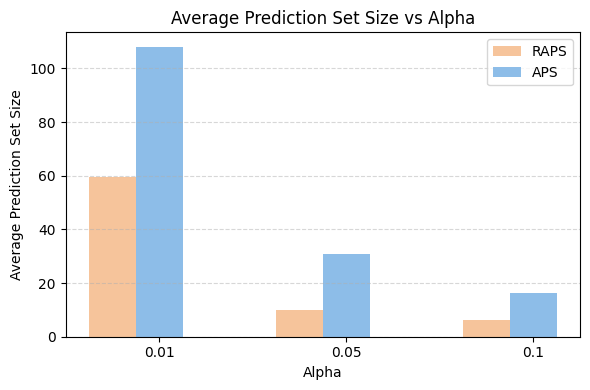

In [16]:

methods = ['RAPS', 'APS']
colors = ['#f6c49b', '#8dbde8']


x = np.arange(len(alphas))
bar_width = 0.25

plt.figure(figsize=(6, 4))


for i, method in enumerate(methods):
    plt.bar(x + i * bar_width, average_sizes[method], width=bar_width, label=method, color=colors[i])
    print("Done with method: ", method)

plt.xticks(x + bar_width, alphas)
plt.xlabel('Alpha')
plt.ylabel('Average Prediction Set Size')
plt.title('Average Prediction Set Size vs Alpha')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('average_prediction_set_size_vgg.png')
plt.show()


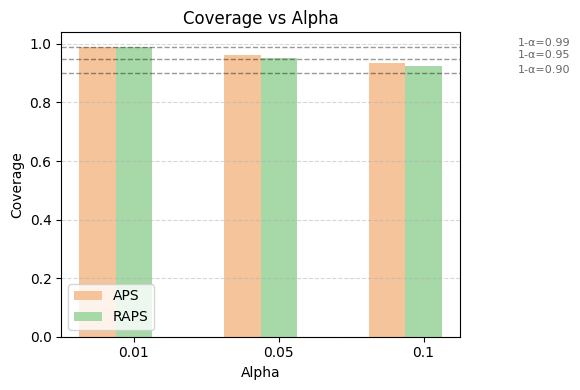

In [17]:

methods = [ 'APS', 'RAPS']
colors = ['#f6c49b', '#a6d8a8']

x = np.arange(len(alphas))
bar_width = 0.25

plt.figure(figsize=(6, 4))

# Plot bars
for i, method in enumerate(methods):
    plt.bar(x + i * bar_width, average_coverages[method], width=bar_width, color=colors[i], label=method)

for i, alpha in enumerate(alphas):
    y = 1 - alpha
    plt.axhline(y=y, color='k', linestyle='--', linewidth=1, alpha=0.4)
    plt.text(len(alphas)-0.1, y + 0.002, f'1-α={y:.2f}', color='k', fontsize=8, alpha=0.6)

plt.xticks(x + bar_width, alphas)
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('coverage_bar_vgg.png', dpi=300)
plt.show()


